# GIGANTES TECNOLÓGICOS

## Importación de los datos

In [1]:
# Import libreries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from functions import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
company_data = download_stock_data("AAPL")
companies = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Alphabet': 'GOOGL',
    'NVIDIA': 'NVDA'
}

## Limpieza de datos

In [4]:
# Normalizar los nombres de las columnas
company_data = normalizar_nombres_columnas(company_data)

In [5]:
data_report = data_quality_report(company_data)

----- Informe de Calidad de Datos -----

Valores nulos por columna:
 open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos:
 open            float64
high            float64
low             float64
close           float64
volume            int64
dividends       float64
stock_splits    float64
dtype: object

Descripción estadística de las columnas numéricas:
               open         high          low        close        volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     90.167572    91.132187    89.259216    90.240001  1.198645e+08   
std      63.228047    63.890383    62.602949    63.281563  6.876906e+07   
min      20.642059    21.025084    20.520499    20.720037  2.404830e+07   
25%      33.489977    33.637213    33.329929    33.467280  7.363212e+07   
50%      57.322024    57.952202    56.794650    57.165985 

### Ingeniería de caracteristicas

Agregar retornos logarítmicos (Log Returns):

Los retornos logarítmicos pueden ser útiles para predecir el comportamiento del precio a futuro, ya que tienden a estabilizar la varianza a lo largo del tiempo.

In [6]:
company_data['log_return'] = np.log(company_data['close'] / company_data['close'].shift(1))
company_data.dropna(inplace=True)  # Eliminar filas con NaN generados por shift

Volatilidad histórica:

La volatilidad es un indicador clave en los mercados financieros y podría ayudarte a capturar la fluctuación de precios a lo largo del tiempo.

In [7]:
company_data['volatility'] = company_data['log_return'].rolling(window=30).std() * np.sqrt(30)
company_data.dropna(inplace=True)  # Eliminar filas con NaN

Media móvil (Moving Average):

Incluir medias móviles de 50 días, 100 días o más largas puede ayudarte a capturar tendencias más generales.

In [8]:
company_data['ma50'] = company_data['close'].rolling(window=50).mean()
company_data['ma100'] = company_data['close'].rolling(window=100).mean()
company_data.dropna(inplace=True)  # Eliminar filas con NaN

Relación entre volumen y precio (Volume-to-Price Ratio):

La relación entre el volumen y el precio puede ser un buen indicador de movimientos significativos en el mercado.

In [9]:
company_data['volume_to_price'] = company_data['volume'] / company_data['close']

Cálculo de retornos

In [10]:
company_data['daily_return'] = company_data['close'].pct_change()

Eliminar nulos posibles generados con la creación de columnas

In [11]:
company_data.dropna(inplace=True)

## Análisis exploratorio de datos (EDA)

In [12]:
company_data.dtypes

open               float64
high               float64
low                float64
close              float64
volume               int64
dividends          float64
stock_splits       float64
log_return         float64
volatility         float64
ma50               float64
ma100              float64
volume_to_price    float64
daily_return       float64
dtype: object

In [13]:
# 1. Descripción general de los datos
describe_data(company_data)

Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2386 entries, 2015-04-30 00:00:00-04:00 to 2024-10-21 00:00:00-04:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2386 non-null   float64
 1   high             2386 non-null   float64
 2   low              2386 non-null   float64
 3   close            2386 non-null   float64
 4   volume           2386 non-null   int64  
 5   dividends        2386 non-null   float64
 6   stock_splits     2386 non-null   float64
 7   log_return       2386 non-null   float64
 8   volatility       2386 non-null   float64
 9   ma50             2386 non-null   float64
 10  ma100            2386 non-null   float64
 11  volume_to_price  2386 non-null   float64
 12  daily_return     2386 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 261.0 KB
None

Primeras 5 filas:
                                open       

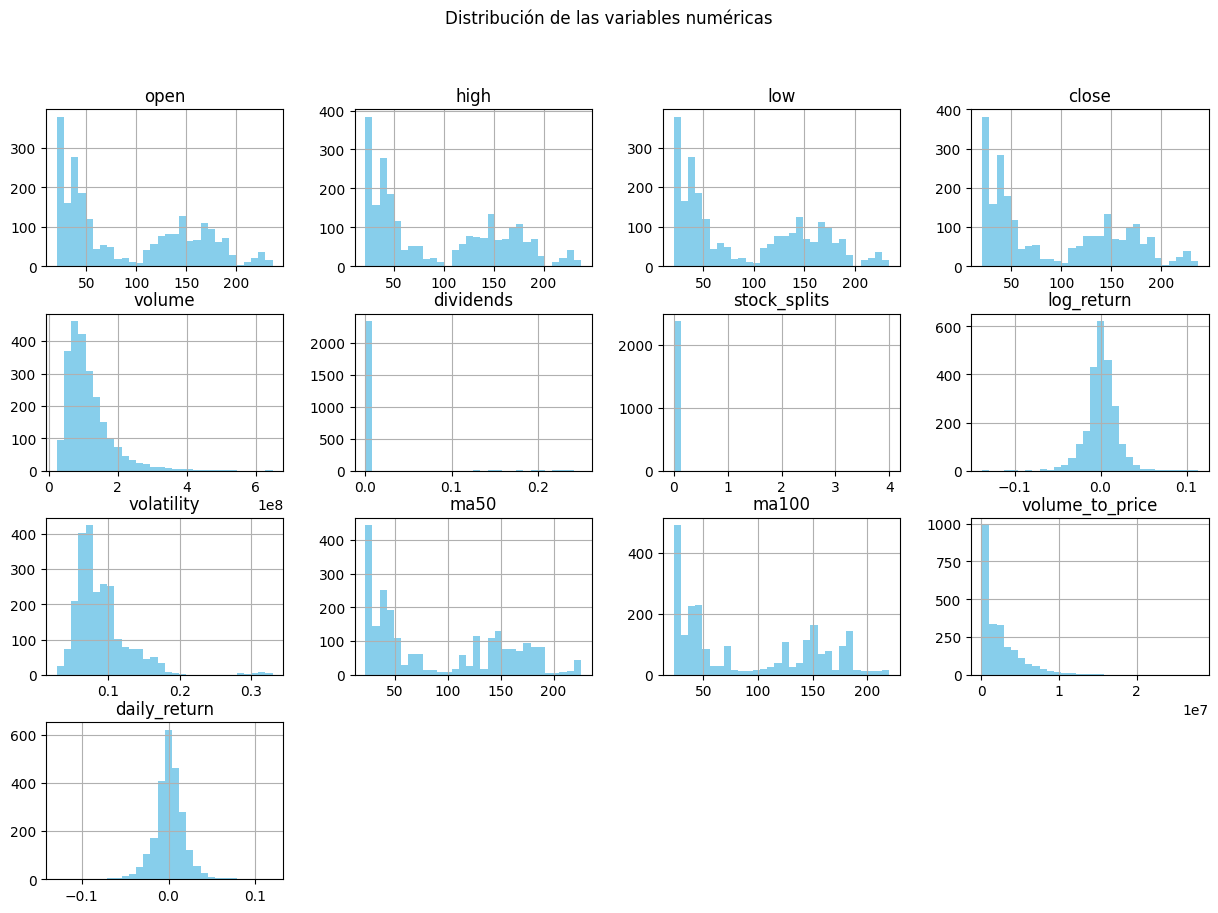

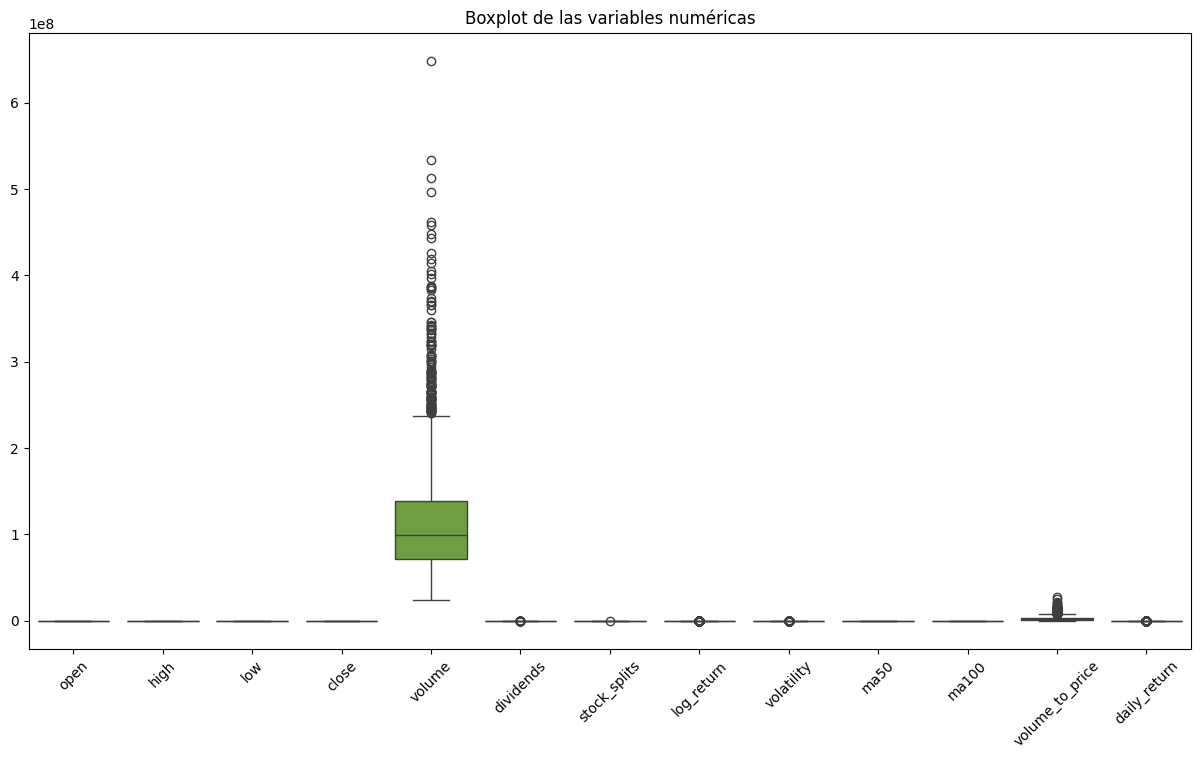

In [14]:
# 2. Visualizar las distribuciones y detectar outliers
plot_distributions(company_data)

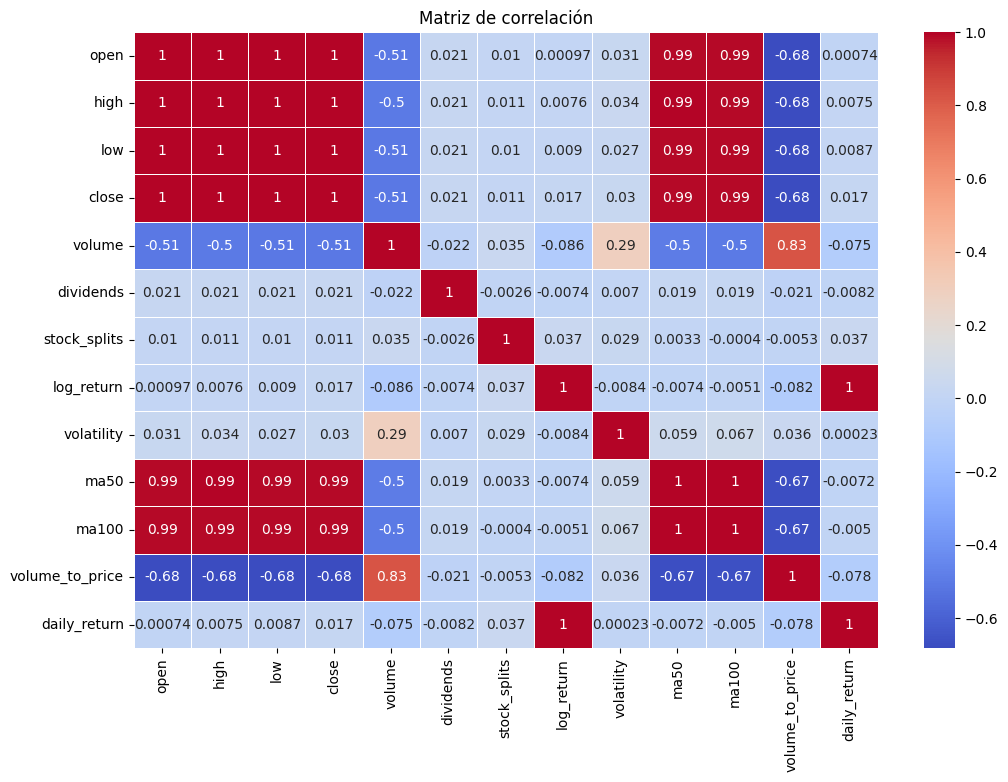

In [15]:
# 3. Matriz de correlación
plot_correlation_matrix(company_data)

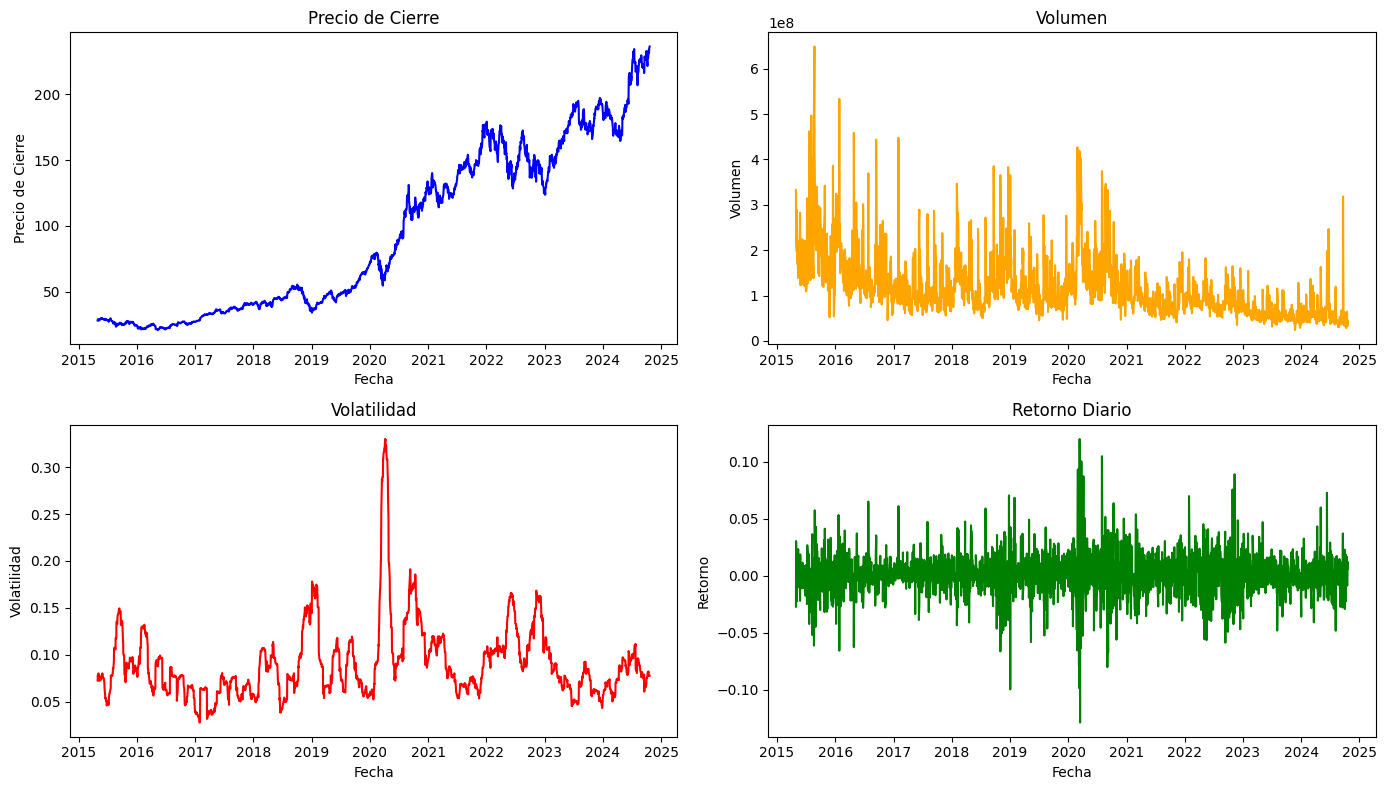

In [16]:
# 4. Visualización de series temporales
plot_time_series(company_data)

In [17]:
# 5. Detección de outliers
detect_outliers(company_data)

Número de outliers por variable:
open                 0
high                 0
low                  0
close                0
volume             120
dividends           38
stock_splits         1
log_return         132
volatility         104
ma50                 0
ma100                0
volume_to_price    116
daily_return       132
dtype: int64


## Modelos comparativa

Preprocesamiento de Datos

In [18]:
# Verificar datos faltantes
print(company_data.isnull().sum())

# Opciones de manejo de datos faltantes
#company_data.fillna(method='ffill', inplace=True)  # Forward Fill para series temporales


open               0
high               0
low                0
close              0
volume             0
dividends          0
stock_splits       0
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
daily_return       0
dtype: int64


 Normalización o Escalado:

In [19]:
# Escalar las variables numéricas
scaler = StandardScaler()
scaled_data = scaler.fit_transform(company_data[['open', 'high', 'low', 'close', 'volume', 'volatility', 'log_return']])
scaled_df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close', 'volume', 'volatility', 'log_return'])

Análisis de la distribución (Normalidad):

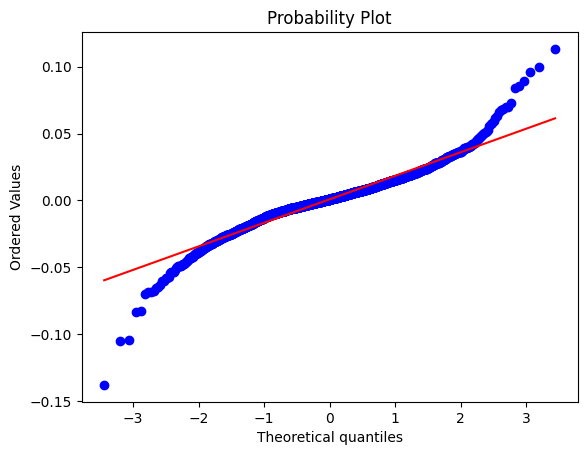

In [20]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Verificación de normalidad
stats.probplot(company_data['log_return'], dist="norm", plot=plt)
plt.show()

# Si es necesario, se pueden aplicar transformaciones
company_data['log_return'] = np.log1p(company_data['log_return'])  # Log-transformación


### Comparativa de modelos

1 Modelos Supervisados

Vamos a aplicar varios modelos supervisados, como regresión lineal, regresión de máquinas de soporte vectorial (SVR) y árboles de decisión para predecir valores futuros. Al final, compararemos estos resultados con Prophet, que está optimizado para series temporales.



1.1 Regresión Lineal: Un modelo básico pero efectivo para ver la relación entre variables.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Dividir los datos en entrenamiento y prueba
X = company_data[['open', 'high', 'low', 'volume', 'volatility', 'ma50', 'ma100']]
y = company_data['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = lin_reg.predict(X_test)
mse_lin_reg = mean_squared_error(y_test, y_pred)
print(f"Regresión Lineal MSE: {mse_lin_reg}")


Regresión Lineal MSE: 0.48387745320998576


1.2 Máquinas de Soporte Vectorial (SVR): El modelo SVR es útil para capturar relaciones no lineales entre las variables.

In [22]:
from sklearn.svm import SVR

# Ajustar el modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")


SVR MSE: 2554.1888668077218


1.3 Árboles de Decisión: Los árboles de decisión pueden manejar relaciones complejas entre variables, pero son propensos a sobreajustarse.

In [23]:
from sklearn.tree import DecisionTreeRegressor

# Ajustar el modelo Árbol de Decisión
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_tree = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Árbol de Decisión MSE: {mse_tree}")


Árbol de Decisión MSE: 1.661396676882086


### Ajuste hiperparámetros

Realizamos el ajuste de hiperparámetros para optimizar los modelos supervisados. Aquí usamos GridSearchCV para ajustar los hiperparámetros de SVR y los árboles de decisión.

In [24]:
from sklearn.model_selection import GridSearchCV

# Ajuste de hiperparámetros para SVR
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
grid_search_svr = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros para SVR:", grid_search_svr.best_params_)


Mejores hiperparámetros para SVR: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Evaluación del Modelo

Finalmente, comparamos los resultados de los modelos usando MSE (Mean Squared Error) o MAE (Mean Absolute Error), lo que permite evaluar cuál modelo se adapta mejor a los datos.

In [25]:
print(f"Comparación de Modelos:")
print(f"Regresión Lineal MSE: {mse_lin_reg}")
print(f"SVR MSE: {mse_svr}")
print(f"Árbol de Decisión MSE: {mse_tree}")


Comparación de Modelos:
Regresión Lineal MSE: 0.48387745320998576
SVR MSE: 2554.1888668077218
Árbol de Decisión MSE: 1.661396676882086


2 Modelo de Series Temporales: Prophet

Finalmente, implementamos Prophet, que es ideal para la predicción de series temporales y captura tendencias y estacionalidades.

14:59:28 - cmdstanpy - INFO - Chain [1] start processing
14:59:28 - cmdstanpy - INFO - Chain [1] done processing


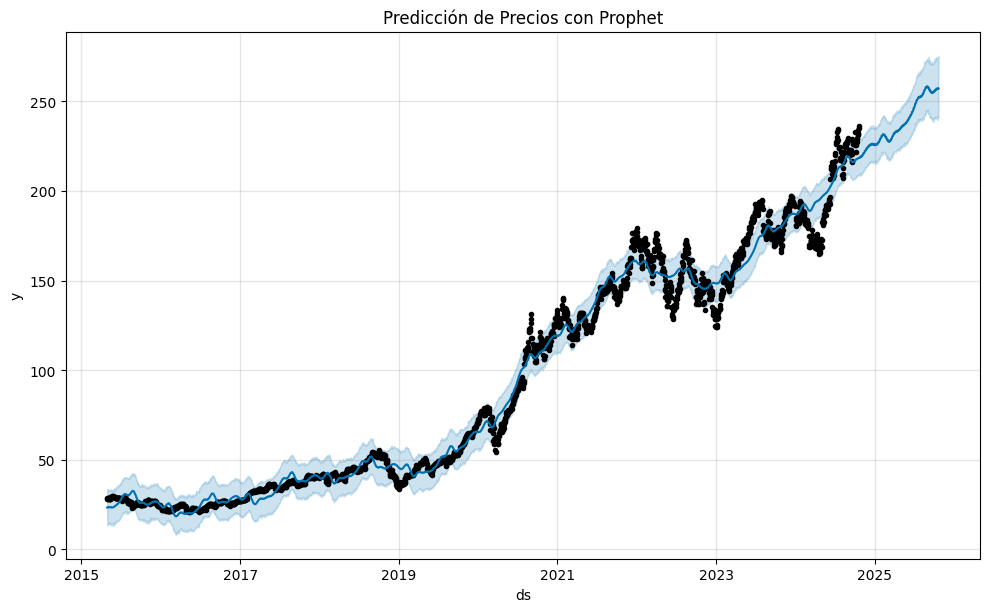

In [26]:
from prophet import Prophet

# Preparar los datos para Prophet
df_prophet = company_data[['close']].reset_index()
df_prophet.columns = ['ds', 'y']

# Eliminar la zona horaria de la columna 'ds'
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(df_prophet)

# Predecir valores futuros
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Mostrar los resultados
model.plot(forecast)
plt.title("Predicción de Precios con Prophet")
plt.show()
